In [1]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt

print('Numpy version = {}'.format(np.__version__))
print('Pandas version = {}'.format(pd.__version__))
print('Matplotlib version = {}'.format(matplotlib.__version__))
print('Scipy version = {}'.format(scipy.__version__))

%matplotlib inline

Numpy version = 1.23.5
Pandas version = 1.5.3
Matplotlib version = 3.8.3
Scipy version = 1.11.3


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras import backend as K
from tensorflow.keras import Model, Input, Sequential, optimizers, callbacks
from tensorflow.keras.layers import Layer, Dense, BatchNormalization

import warnings
warnings.filterwarnings('ignore')

print('TensorFlow version = {}'.format(tf.__version__))

tfd = tfp.distributions
tf.keras.backend.clear_session()

2024-11-05 19:04:11.087489: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 19:04:11.140390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version = 2.13.1


# Attempting To Quantify Uncertainty Of Higgs Boson Mass Estimate Using Bayesian Neural Networks

<font size="3">The dataset that I used can be downloaded from http://opendata.cern.ch/record/328. The webpage also includes a brief explanation of the variables in the dataset. A slightly more detailed description can be found in https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf.</font> 
    
<font size="3">The Higgs Boson Machine Learning Challenge on Kaggle used this dataset to challenge participants to develop a ML model that correctly classified Higgs production signal events against Standard Model background events that could mimic the signal process. The challenge simulates the discovery of the Higgs boson in the decay channel $H \to \tau^{+} \tau^{-}$, where one tau **decays hadronically** $\left( \tau_{h} \to (W \to q q')\bar{\nu}_{\tau} \right)$ and the other **decays leptonically** $\left(\tau_{\ell} \to (W \to \ell \bar{\nu}_{\ell})\bar{\nu}_{\tau} \right)$, where the **lepton** $\ell$ is either an electron or muon. The Standard Model background events include processes that can produce a $\tau$, such as top anti-top quark pair production events ($t\bar{t}$), $W$ boson production events, and $Z$ boson production events.</font> 
    
<font size="3">The dataset contains Monte Carlo (MC) simulations of the processes previously mentioned. The hadronically decaying $\tau$ will typically produce pion particles ($\pi^{+}, \pi^{-}, \pi^{0}$) and a tau neutrino ($\nu_{\tau}$). The pions will continue to decay as they interact with the detector material, depositing the majority of their energy in the hadronic calorimeter system of the ATLAS detector. The pions are reconstructed as objects known as **jets** using primarily the energy measurements from the hadronic calorimeter. The dataset contains jet-related variables such as the **number of jets** reconstructed in the event, the **transverse momentum** ($p_{T}$) of the most energetic jet in the event (**leading**), and the second most energetic jet in the event (**subleading**). The $\nu_{\tau}$ will leave the detector without depositing its energy due to neutrinos being practically massless; thus, the presence of neutrinos is inferred from **missing energy** $\left(\vec{E}^{miss}_{T}\right)$ in an event. The leptonically decaying tau is a large source of missing energy since it produces two neutrinos and a single electron or muon, which deposit their energy in the electromagnetic calorimeter. The dataset contains variables related to the missing energy (**MET**) and the lepton (**lep**). Additionally, the dataset contains variables that quantify angular separations between different objects such as the hadronically decaying tau and the lepton, the total momentum of all particles produced in the event, and the invariant mass of two-particle systems such as the lepton and hadronically decaying tau. A full description of the variables can be found in the links provided above.</font>

<font size="3"> The purpose of many particle collision experiments is to produce a yet undiscovered particle. A statistical analysis is carried out to determine if the data collected from the experiment accepts or rejects the hypothesis of discovering the particle. This is usually done by performing a likelihood fit on a distribution of the reconstructed mass of the candidate undiscovered particle. One of the variables included in the dataset is the **estimated Higgs mass** ($m_{H}$), which is obtained by performing a MC integration of the analysis phase space. However, some events in the dataset have an undefined value for the Higgs mass estimate ($m_{H} = -999$) since the event kinematics reside in regions of the phase space that are far away from the bulk of the dataset and produce unreliable mass estimates. Events that don't have a mass estimate are discarded from the statistical analysis, which can have a negative impact if the analysis is limited to available statistics.</font>

<font size="3">I decided to train a Bayesian neural network that predicts the value of the estimated Higgs mass in signal Higgs production events where the estimate is not defined. The Bayesian neural network will be trained and tested using Higgs production events with available mass estimates to then produce an ensemble of estimate predictions for events with undefined Higgs mass values. Additionally, I also simulated a source of systematic uncertainty in the measurement of the transverse momentum of the hadronically decaying tau and propagated its effects to the Bayesian neural network prediction. This will serve as a test of how sensitive the network's prediction of the Higgs mass is to the hadronically decaying tau $p_{T}$.</font>

# Loading The Dataset

In [3]:
dataset = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')

print('Head:\n', dataset.describe(), '\n')

print('Class distribution:\n', dataset.groupby('Label').size(), '\n')

Head:
              EventId   DER_mass_MMC  DER_mass_transverse_met_lep  \
count  818238.000000  818238.000000                818238.000000   
mean   509118.500000     -48.819019                    49.252714   
std    236205.109118     406.118397                    35.378609   
min    100000.000000    -999.000000                     0.000000   
25%    304559.250000      78.166000                    19.304000   
50%    509118.500000     105.061000                    46.484000   
75%    713677.750000     130.730000                    73.620000   
max    918237.000000    1949.261000                   968.669000   

        DER_mass_vis       DER_pt_h  DER_deltaeta_jet_jet  DER_mass_jet_jet  \
count  818238.000000  818238.000000         818238.000000     818238.000000   
mean       81.140561      57.849524           -707.740880       -600.191191   
std        40.582708      63.411938            454.793899        658.724040   
min         6.329000       0.000000           -999.000000       

<font size="3">There are 279560 signal Higgs production events in this dataset. Let's retrieve them:</font>

In [4]:
event_class_labels = pd.get_dummies(dataset.Label).values[:,0]

higgs_production_events = np.array(event_class_labels == 0)

# This dataset will contain the nominal sample (no systematic variation applied to the tau pT).
dataset_nominal = dataset[higgs_production_events]

# This dataset will contain the systematically varied sample.
dataset_systvar = dataset[higgs_production_events]

# Applying Systematic Variation On The Hadronically Decaying Tau Transverse Momentum

<font size="3">To simulate a systematic variation on the detector resolution of the hadronically decaying tau transverse momentum, I smeared the values of the transverse momentum components $p_{x}$ and $p_{y}$ using a Gaussian distribution with $\mu = 0$ and $\sigma = 7$. Thus, the systematically varied transverse momentum is given by:
        $$
            p_{T}^{\text{syst. var.}} = \sqrt{\left( (p_{x} + \mathcal{N}_{x}(\mu = 0,\, \sigma = 7))^{2} + (p_{y} + \mathcal{N}_{y}(\mu = 0,\, \sigma = 7))^{2} \right)}
        $$
</font>

In [5]:
mu, sigma = 0, 7

tau_px_smear = np.random.normal(mu, sigma, dataset_systvar.shape[0])

tau_py_smear = np.random.normal(mu, sigma, dataset_systvar.shape[0])

# Calculate the px = pT*cos(phi) and py = pT*sin(phi) momentum components since they are not included in the original dataset, and apply the smearing.
dataset_systvar['TMP_tau_px'] = ((dataset_systvar['PRI_tau_pt']*np.cos(dataset_systvar['PRI_tau_phi'])) + tau_px_smear)
dataset_systvar['TMP_tau_py'] = ((dataset_systvar['PRI_tau_pt']*np.sin(dataset_systvar['PRI_tau_phi'])) + tau_py_smear)
    
# Calculate the systematically varied pT of the hadronically decaying tau.
dataset_systvar['PRI_tau_pt'] = np.sqrt(((dataset_systvar['TMP_tau_px'])**2) + ((dataset_systvar['TMP_tau_py'])**2))

# Propagate the systematic variation to the azimuthal angle of the hadronically decaying tau.
dataset_systvar['PRI_tau_phi']= np.arctan2(dataset_systvar['TMP_tau_py'], dataset_systvar['TMP_tau_px'])
    
# Define additional temporary variables that will be needed to propagate the systematic variation to the dataset.

# Total momentum magnitude of the tau and lepton.
dataset_systvar['TMP_tau_p_tot'] = dataset_systvar['PRI_tau_pt']*np.cosh(dataset_systvar['PRI_tau_eta'])
dataset_systvar['TMP_lep_p_tot'] = dataset_systvar['PRI_lep_pt']*np.cosh(dataset_systvar['PRI_lep_eta'])

# z-axis (detector beamline) momentum component of the tau.
dataset_systvar['TMP_tau_pz'] = dataset_systvar['PRI_tau_pt']*np.sinh(dataset_systvar['PRI_tau_eta'])

# Cartesian momentum components of the lepton.
dataset_systvar['TMP_lep_px'] = dataset_systvar['PRI_lep_pt']*np.cos(dataset_systvar['PRI_lep_phi'])
dataset_systvar['TMP_lep_py'] = dataset_systvar['PRI_lep_pt']*np.sin(dataset_systvar['PRI_lep_phi'])
dataset_systvar['TMP_lep_pz'] = dataset_systvar['PRI_lep_pt']*np.sinh(dataset_systvar['PRI_lep_eta'])

# Transverse plane momentum components of the leading jet.
dataset_systvar['TMP_jet_leading_px'] = dataset_systvar['PRI_jet_leading_pt']*np.cos(dataset_systvar['PRI_jet_leading_phi'])
dataset_systvar['TMP_jet_leading_py'] = dataset_systvar['PRI_jet_leading_pt']*np.sin(dataset_systvar['PRI_jet_leading_phi'])

# Transverse plane momentum components of the sub-leading jet. 
dataset_systvar['TMP_jet_subleading_px'] = dataset_systvar['PRI_jet_subleading_pt']*np.cos(dataset_systvar['PRI_jet_subleading_phi'])
dataset_systvar['TMP_jet_subleading_py'] = dataset_systvar['PRI_jet_subleading_pt']*np.sin(dataset_systvar['PRI_jet_subleading_phi'])

# Transverse plane missing energy components.
dataset_systvar['TMP_met_px'] = dataset_systvar['PRI_met']*np.cos(dataset_systvar['PRI_met_phi'])
dataset_systvar['TMP_met_py'] = dataset_systvar['PRI_met']*np.sin(dataset_systvar['PRI_met_phi'])

# Azimuthal angle distance between the hadronically decaying tau and lepton. Need to ensure that this value is between -pi and pi.
dataset_systvar['TMP_deltaphi_tau_lep'] = dataset_systvar['PRI_tau_phi'] - dataset_systvar['PRI_lep_phi']
dataset_systvar['TMP_deltaphi_tau_lep'][dataset_systvar['TMP_deltaphi_tau_lep'] >= np.pi] -= 2.0*np.pi
dataset_systvar['TMP_deltaphi_tau_lep'][dataset_systvar['TMP_deltaphi_tau_lep'] < -np.pi] += 2.0*np.pi

<font size="3">The following variables in the dataset need to be recalculated in order to propagate the systematic variation of the hadronic tau $p_{T}$ because they depend explicitly on the values of $p_{\tau,x},\, p_{\tau,x},\, p_{\tau,T}$ and $\phi_{\tau}$:
    $
    \begin{align}
    &\text{DER_mass_vis} = \sqrt{\left(  \sqrt{p_{\tau,x}^{2} + p_{\tau,y}^{2} + p_{\tau,z}^{2}} + \sqrt{p_{\ell, x}^{2} + p_{\ell,y}^{2} + p_{\ell,z}^{2}} \right)^{2} 
    - \left( (p_{\tau,x} + p_{\ell, x})^{2} + (p_{\tau,y} + p_{\ell, y})^{2} + (p_{\tau,z} + p_{\ell, z})^{2}\right)} \\
    &\text{DER_pt_h} = \sqrt{ \left(p_{\tau,x} + p_{\ell, x} + E_{T,x}^{miss} \right)^{2} + \left(p_{\tau,y} + p_{\ell, y} + E_{T,y}^{miss} \right)^{2}} \\
    &\text{DER_deltar_tau_lep} = \sqrt{((\phi_{\tau} - \phi_{\ell})\text{mod}\,2\pi)^{2} + (\eta_{\tau} - \eta_{\ell})^{2}} \\
    &\text{DER_sum_pt} = p_{\tau,T} + p_{\ell, T} + \sum_{j \in \text{event jets}} p_{j, T} \\
    &\text{DER_pt_ratio_lep_tau} = p_{\ell, T}/p_{\tau, T}
    \end{align}
    $
</font>

In [6]:
# Propagating the systematic variation to the derived variables.
dataset_systvar['DER_mass_vis'] = np.sqrt(((dataset_systvar['TMP_tau_p_tot'] + dataset_systvar['TMP_lep_p_tot'])**2) - 
                                          ((dataset_systvar['TMP_tau_px'] + dataset_systvar['TMP_lep_px'])**2) - 
                                          ((dataset_systvar['TMP_tau_py'] + dataset_systvar['TMP_lep_py'])**2) - 
                                          ((dataset_systvar['TMP_tau_pz'] + dataset_systvar['TMP_lep_pz'])**2))


dataset_systvar['DER_pt_h'] = np.sqrt(((dataset_systvar['TMP_tau_px'] + dataset_systvar['TMP_lep_px'] + dataset_systvar['TMP_met_px'])**2) +
                                      ((dataset_systvar['TMP_tau_py'] + dataset_systvar['TMP_lep_py'] + dataset_systvar['TMP_met_py'])**2))


dataset_systvar['DER_deltar_tau_lep'] = np.sqrt(((dataset_systvar['TMP_deltaphi_tau_lep'])**2) + ((dataset_systvar['PRI_tau_eta'] - dataset_systvar['PRI_lep_eta'])**2))


dataset_systvar['DER_pt_tot'] = np.sqrt(((dataset_systvar['TMP_tau_px'] + dataset_systvar['TMP_lep_px'] + dataset_systvar['TMP_met_px'] + 
                                        ((dataset_systvar['PRI_jet_num'] > 0)*dataset_systvar['TMP_jet_leading_px']) + 
                                        ((dataset_systvar['PRI_jet_num'] > 1)*dataset_systvar['TMP_jet_subleading_px']))**2) +
                                        ((dataset_systvar['TMP_tau_py'] + dataset_systvar['TMP_lep_py'] + dataset_systvar['TMP_met_py'] +
                                        ((dataset_systvar['PRI_jet_num'] > 0)*dataset_systvar['TMP_jet_leading_py']) + 
                                        ((dataset_systvar['PRI_jet_num'] > 1)*dataset_systvar['TMP_jet_subleading_py']))**2))

dataset_systvar['DER_sum_pt'] = dataset_systvar['PRI_tau_pt'] + dataset_systvar['PRI_lep_pt'] + dataset_systvar['PRI_jet_all_pt']


dataset_systvar['DER_pt_ratio_lep_tau'] = dataset_systvar['PRI_lep_pt']/dataset_systvar['PRI_tau_pt']

In [7]:
# Remove all temporary variables that were needed for intermediate calculations.
dataset_systvar.drop(['TMP_tau_px', 'TMP_tau_py', 'TMP_tau_pz', 'TMP_tau_p_tot','TMP_lep_px', 'TMP_lep_py', 'TMP_lep_pz', 'TMP_lep_p_tot',
                      'TMP_jet_leading_px', 'TMP_jet_leading_py', 'TMP_jet_subleading_px','TMP_jet_subleading_py', 'TMP_met_px', 'TMP_met_py', 
                      'TMP_deltaphi_tau_lep'], axis = 1, inplace = True)

# Splitting The Data For Training, Testing, and Predicting

In [8]:
# First split the data between events that have a well-defined Higgs mass (DER_mass_MMC >= 0) and an undefined Higgs mass (DER_mass_MMC < 0).

# Events with a well-defined Higgs mass will be used to train and validate the Bayesian neural network.
X_train_test_nominal = dataset_nominal[dataset_nominal['DER_mass_MMC'] >= 0]

# Events with an undefined Higgs mass will be used to obtain a prediction.
X_prediction_nominal = dataset_nominal[dataset_nominal['DER_mass_MMC'] < 0]

# These are the values that the Bayesian neural network will learn to predict.
y_train_test_nominal = X_train_test_nominal['DER_mass_MMC'].values

# Perform the same splitting on the systematically varied events.
# The nominal and systematically varied events are in a one-to-one correspondence since the value of
# DER_mass_MMC is not altered, so the ordering of the events is preserved.
X_train_test_systvar = dataset_systvar[dataset_systvar['DER_mass_MMC'] >= 0]

X_prediction_systvar = dataset_systvar[dataset_systvar['DER_mass_MMC'] < 0]

y_train_test_systvar = X_train_test_systvar['DER_mass_MMC'].values

In [9]:
# Remove metadata variables.
variables_to_drop = ['Label', 'EventId', 'Weight', 'KaggleSet', 'KaggleWeight', 'DER_mass_MMC', 'DER_met_phi_centrality']


X_train_test_nominal = X_train_test_nominal.drop(variables_to_drop, axis = 1, inplace = False)
X_prediction_nominal = X_prediction_nominal.drop(variables_to_drop, axis = 1, inplace = False)

X_train_test_systvar = X_train_test_systvar.drop(variables_to_drop, axis = 1, inplace = False)
X_prediction_systvar = X_prediction_systvar.drop(variables_to_drop, axis = 1, inplace = False)

In [10]:
print("There are {} events with well-defined Higgs mass and {} events with undefined Higgs mass.".format(X_train_test_nominal.shape[0], X_prediction_nominal.shape[0]))

There are 270371 events with well-defined Higgs mass and 9189 events with undefined Higgs mass.


In [11]:
# Get the feature matrix for the nominal and systematically varied events.
X_train_test_nominal = X_train_test_nominal.to_numpy()
X_prediction_nominal = X_prediction_nominal.to_numpy()

X_train_test_systvar = X_train_test_systvar.to_numpy()
X_prediction_systvar = X_prediction_systvar.to_numpy()

# Use approximately 1/3 of the well-defined Higgs mass events for training.
X_train_nominal = X_train_test_nominal[:90000]
y_train_nominal = y_train_test_nominal[:90000]

# The remaining 2/3 events will be used for validation.
X_test_nominal = X_train_test_nominal[90000:]
y_test_nominal = y_train_test_nominal[90000:]

# Building the Bayesian Neural Network (BNN) Model

<font size="3">The Bayesian neural network that I trained is relatively simple, with only two hidden layers. Each layer is implemented as a DenseFlipout layer, which contains a distribution of the model's weights that will allow us to quantify the uncertainty of the network. Additionally, the DenseFlipout layer is more efficient when using large datasets compared to other options used for probabilistic machine learning. The sigmoid activation function is used in the hidden layers to add non-linearity, while the output layer uses the relu activation function in order to force the output to be positive $(m_{H} > 0)$. Each layer implements the Kullback-Leibler (KL) divergence between the variational distribution and the true posterior, which is minimized in order to determine the variational parameters. The loss function that the model uses is the negative log likehood of a Gaussian distribution.</font>

In [12]:
def neg_log_likelihood(y_obs, y_pred, sigma=1.0):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

batch_size = 500

n_batches = X_train_nominal.shape[0]/ batch_size

kl_divergence_function = (lambda p, q, _: tfd.kl_divergence(p, q) / tf.cast(n_batches, dtype=tf.float32))

model = Sequential()

model.add(Input(shape = (X_train_nominal.shape[1],)))

model.add(BatchNormalization())

model.add(tfp.layers.DenseFlipout(20, kernel_divergence_fn = kl_divergence_function, activation = 'sigmoid'))

model.add(tfp.layers.DenseFlipout(20, kernel_divergence_fn = kl_divergence_function, activation = 'sigmoid'))

model.add(tfp.layers.DenseFlipout(10, kernel_divergence_fn = kl_divergence_function, activation = 'sigmoid'))

# Use relu as activation in the final layer since the output must be a positive value.
model.add(tfp.layers.DenseFlipout(1, kernel_divergence_fn = kl_divergence_function, activation = 'relu'))

model.compile(loss = neg_log_likelihood, optimizer = optimizers.Adam(learning_rate = 0.005), metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [13]:
history = model.fit(X_train_nominal, y_train_nominal, batch_size = batch_size, epochs = 250, verbose = 1, shuffle = True, validation_data = (X_test_nominal, y_test_nominal))

Epoch 1/250
180/180 [==============================] - 6s 15ms/step - loss: 3594582.2500 - root_mean_squared_error: 119.9017 - val_loss: 3287622.5000 - val_root_mean_squared_error: 114.6970
Epoch 2/250
180/180 [==============================] - 2s 9ms/step - loss: 3026363.7500 - root_mean_squared_error: 110.0162 - val_loss: 2774534.5000 - val_root_mean_squared_error: 105.3659
Epoch 3/250
180/180 [==============================] - 2s 9ms/step - loss: 2550502.5000 - root_mean_squared_error: 100.9956 - val_loss: 2332871.5000 - val_root_mean_squared_error: 96.6147
Epoch 4/250
180/180 [==============================] - 2s 9ms/step - loss: 2139869.2500 - root_mean_squared_error: 92.5072 - val_loss: 1951294.6250 - val_root_mean_squared_error: 88.3589
Epoch 5/250
180/180 [==============================] - 2s 9ms/step - loss: 1785731.6250 - root_mean_squared_error: 84.5046 - val_loss: 1623049.3750 - val_root_mean_squared_error: 80.5831
Epoch 6/250
180/180 [==============================] - 2s 9

180/180 [==============================] - 2s 9ms/step - loss: 67092.0000 - root_mean_squared_error: 16.3229 - val_loss: 58668.1133 - val_root_mean_squared_error: 15.2591
Epoch 46/250
180/180 [==============================] - 2s 9ms/step - loss: 65606.6562 - root_mean_squared_error: 16.1398 - val_loss: 56662.7148 - val_root_mean_squared_error: 14.9936
Epoch 47/250
180/180 [==============================] - 2s 9ms/step - loss: 64263.6641 - root_mean_squared_error: 15.9724 - val_loss: 55401.5664 - val_root_mean_squared_error: 14.8243
Epoch 48/250
180/180 [==============================] - 2s 9ms/step - loss: 63112.9102 - root_mean_squared_error: 15.8276 - val_loss: 54562.2617 - val_root_mean_squared_error: 14.7106
Epoch 49/250
180/180 [==============================] - 2s 9ms/step - loss: 61837.9453 - root_mean_squared_error: 15.6656 - val_loss: 52829.8750 - val_root_mean_squared_error: 14.4729
Epoch 50/250
180/180 [==============================] - 2s 9ms/step - loss: 60606.8438 - root

180/180 [==============================] - 2s 9ms/step - loss: 32190.8984 - root_mean_squared_error: 11.2580 - val_loss: 26373.6211 - val_root_mean_squared_error: 10.1734
Epoch 90/250
180/180 [==============================] - 2s 9ms/step - loss: 32139.0625 - root_mean_squared_error: 11.2487 - val_loss: 25587.6523 - val_root_mean_squared_error: 10.0175
Epoch 91/250
180/180 [==============================] - 2s 9ms/step - loss: 31842.6934 - root_mean_squared_error: 11.1958 - val_loss: 26276.1816 - val_root_mean_squared_error: 10.1541
Epoch 92/250
180/180 [==============================] - 2s 9ms/step - loss: 31251.0293 - root_mean_squared_error: 11.0895 - val_loss: 24956.7969 - val_root_mean_squared_error: 9.8905
Epoch 93/250
180/180 [==============================] - 2s 9ms/step - loss: 30484.8672 - root_mean_squared_error: 10.9504 - val_loss: 26630.1875 - val_root_mean_squared_error: 10.2234
Epoch 94/250
180/180 [==============================] - 2s 9ms/step - loss: 30708.3516 - root_

Epoch 134/250
180/180 [==============================] - 2s 9ms/step - loss: 22813.5000 - root_mean_squared_error: 9.4419 - val_loss: 17712.2695 - val_root_mean_squared_error: 8.2920
Epoch 135/250
180/180 [==============================] - 2s 9ms/step - loss: 22675.1113 - root_mean_squared_error: 9.4124 - val_loss: 19530.6562 - val_root_mean_squared_error: 8.7195
Epoch 136/250
180/180 [==============================] - 2s 9ms/step - loss: 22246.6055 - root_mean_squared_error: 9.3209 - val_loss: 17606.2578 - val_root_mean_squared_error: 8.2662
Epoch 137/250
180/180 [==============================] - 2s 9ms/step - loss: 22352.0664 - root_mean_squared_error: 9.3434 - val_loss: 17820.4062 - val_root_mean_squared_error: 8.3178
Epoch 138/250
180/180 [==============================] - 2s 9ms/step - loss: 22129.7559 - root_mean_squared_error: 9.2956 - val_loss: 17358.0020 - val_root_mean_squared_error: 8.2056
Epoch 139/250
180/180 [==============================] - 2s 9ms/step - loss: 22047.81

Epoch 179/250
180/180 [==============================] - 2s 9ms/step - loss: 18661.1738 - root_mean_squared_error: 8.5128 - val_loss: 15421.7480 - val_root_mean_squared_error: 7.7153
Epoch 180/250
180/180 [==============================] - 2s 9ms/step - loss: 18567.4316 - root_mean_squared_error: 8.4906 - val_loss: 15934.7783 - val_root_mean_squared_error: 7.8469
Epoch 181/250
180/180 [==============================] - 2s 9ms/step - loss: 18566.1777 - root_mean_squared_error: 8.4903 - val_loss: 17786.2852 - val_root_mean_squared_error: 8.3055
Epoch 182/250
180/180 [==============================] - 2s 9ms/step - loss: 19052.1152 - root_mean_squared_error: 8.6039 - val_loss: 15355.1953 - val_root_mean_squared_error: 7.6975
Epoch 183/250
180/180 [==============================] - 2s 9ms/step - loss: 18400.7363 - root_mean_squared_error: 8.4510 - val_loss: 14853.5820 - val_root_mean_squared_error: 7.5659
Epoch 184/250
180/180 [==============================] - 2s 9ms/step - loss: 18513.63

Epoch 224/250
180/180 [==============================] - 2s 9ms/step - loss: 16829.5898 - root_mean_squared_error: 8.0667 - val_loss: 13443.2363 - val_root_mean_squared_error: 7.1790
Epoch 225/250
180/180 [==============================] - 2s 9ms/step - loss: 16224.2607 - root_mean_squared_error: 7.9152 - val_loss: 13910.6328 - val_root_mean_squared_error: 7.3081
Epoch 226/250
180/180 [==============================] - 2s 9ms/step - loss: 16515.8750 - root_mean_squared_error: 7.9884 - val_loss: 13517.9111 - val_root_mean_squared_error: 7.1997
Epoch 227/250
180/180 [==============================] - 2s 9ms/step - loss: 15999.9648 - root_mean_squared_error: 7.8581 - val_loss: 13364.8604 - val_root_mean_squared_error: 7.1569
Epoch 228/250
180/180 [==============================] - 2s 9ms/step - loss: 15771.4209 - root_mean_squared_error: 7.7996 - val_loss: 13501.0068 - val_root_mean_squared_error: 7.1948
Epoch 229/250
180/180 [==============================] - 2s 9ms/step - loss: 16371.53

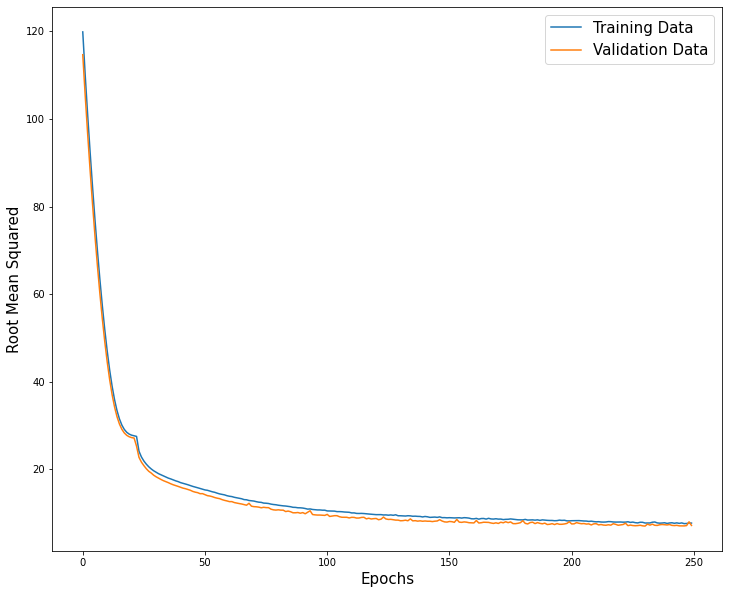

In [14]:
fig, axs = plt.subplots(figsize = (12, 10))

axs.plot(history.history['root_mean_squared_error'], label = 'Training Data')
axs.plot(history.history['val_root_mean_squared_error'], label = 'Validation Data')
axs.set_xlabel('Epochs', fontsize = 15)
axs.set_ylabel('Root Mean Squared', fontsize = 15)
axs.legend(fontsize = 15)

# Making Ensemble Predictions Of The Higgs Mass

<font size="3">We will now use the Bayesian neural network trained on events with defined Higgs mass values to make predictions. First, we perform an ensemble of $N$ predictions on the events of the training data to obtain a mean $\mu^{\text{event}}_{\text{trial}}$ and standard deviation $\sigma^{\text{event}}_{\text{trial}}$ of the predicted Higgs mass. This will be done individually for the nominal and systematically varied dataset. As a simple approximation for quantifying the network's uncertainty on the Higgs mass, we model each ensemble as a binominal random variable $X \sim B(n=N, p)$ where the probability parameter $p$ is obtained by assuming that the values of the Higgs mass prediction ensemble follow a normal distribution $\mathcal{N}(\mu^{\text{event}}_{\text{trial}},\, \sigma^{\text{event}}_{\text{trial}})$. Using the target mass values $m_{H}$ that the Bayesian network was trained on, we quantify the probability $p$ for each event as:
$$
p = \int_{0}^{\frac{(m_{H}-\mu^{\text{event}}_{\text{trial}})}{\sqrt{2}\sigma^{\text{event}}_{\text{trial}}}} \frac{1}{\sqrt{2\pi}}e^{-x^2}dx.
$$
Finally, the total error for the event is calculated as the sum in quadrature of two binomial random variables; one from the nominal predictions, and the other from the systematically varied predictions: 
$$
\sqrt{N \left(p_{\text{nominal}}\left(1-p_{\text{nominal}}\right) + p_{\text{syst. var.}}\left(1-p_{\text{syst. var.}}\right) \right)}
$$ 
</font>

<font size="3">As a last step, we will generate predictions of the Higgs mass using the data with undefined Higgs mass values. We will then verify if the distribution obtained agrees with the distribution obtained from the training data within the total error.</font>

In [15]:
# Function that takes the Bayesian neural network model and feature matrix X
# and produces an ensemble of predictions of size n_experiments for each
# event in X. The function returns the mean, standard deviation, and the
# ensemble for each event.
def run_prediction_experiments(model, X, n_experiments = 20):
    
    prediction_list = []
    
    for i in range(n_experiments):
        
        prediction = model.predict(X)
        
        prediction_list.append(prediction)
        
    prediction_list = np.concatenate(prediction_list, axis = 1)
    
    prediction_mean = np.mean(prediction_list, axis = 1)
    
    prediction_stdv = np.std(prediction_list, axis = 1)
    
    return (prediction_mean, prediction_stdv, prediction_list)

# Function that plots a histogram of the predicted Higgs mass with propagated errors.
def plot_higgs_mass_histogram(axs, bin_low_edges, data, label, unit_normalize = True, color = 'black', marker = 'o', data_uncertainty = None):
    
    n_bins = len(bin_low_edges)
    
    bin_width = bin_low_edges[1] - bin_low_edges[0]
     
    bin_centers = (bin_low_edges[1:] + bin_low_edges[:n_bins - 1])/2.0
    
    # Overflow bin.
    bin_centers = np.append(bin_centers, bin_low_edges[-1] + bin_width/2.0)
    
    # Bin entries are the number of events for which the Higgs mass is inside the bin interval.
    bin_counts = np.array([np.sum((data >= bin_low_edges[i]) & (data < bin_low_edges[i+1])) for i in range(n_bins - 1)])
    
    # Overflow counts.
    bin_counts = np.append(bin_counts, np.sum(data >= bin_low_edges[-1]))
    
    bin_x_errors = (bin_width/2.0)*np.ones(n_bins)
    
    if data_uncertainty is not None:
    
        # Add the total error of all events that are fall into the histogram bin.
        bin_y_errors = np.array([np.sum(data_uncertainty[(data >= bin_low_edges[i]) & (data < bin_low_edges[i+1])]) for i in range(n_bins - 1)])
    
        # Overflow bin error.
        bin_y_errors = np.append(bin_y_errors, np.sum(data_uncertainty[data >= bin_low_edges[-1]]))
    
        bin_y_errors = np.sqrt(bin_counts * bin_y_errors)
    else:
        bin_y_errors = np.sqrt(bin_counts)
    
    # Divide by the histogram integral if we want to produce a unit normalized histogram.
    norm_factor = np.sum(bin_counts) if unit_normalize else 1.0
    
    axs.errorbar(bin_centers, bin_counts/norm_factor, xerr = bin_x_errors, yerr = bin_y_errors/norm_factor, fmt = 'o', color = color, marker = marker, label = label)

In [16]:
# Obtain 10 predictions per event, their mean, and their standard deviation. This simulates the binomial trial experiment.

trials = 10

# Predictions of nominal events with defined Higgs mass (used during training and validation).
defined_mass_predictions_nominal_mean, defined_mass_predictions_nominal_stdv, defined_mass_predictions_nominal = run_prediction_experiments(model, X_train_test_nominal, n_experiments = trials)

# Predictions of systematically varied events with defined Higgs mass (quantify the network's response to systematic uncertainties). 
defined_mass_predictions_systvar_mean, defined_mass_predictions_systvar_stdv, defined_mass_predictions_systvar = run_prediction_experiments(model, X_train_test_systvar, n_experiments = trials)

8450/8450 [==============================] - 15s 2ms/step


In [17]:
# Calculate the total error of the Bayesian neural network prediction by assuming that the predicted Higgs mass values are normally distributed.
nominal_error = norm.cdf((y_train_test_nominal - defined_mass_predictions_nominal_mean)/defined_mass_predictions_nominal_stdv)

# Binomial distribution variance = N*p*(1-p)
nominal_error = trials * (nominal_error * (1-nominal_error))

systvar_error = norm.cdf((y_train_test_systvar - defined_mass_predictions_systvar_mean)/defined_mass_predictions_systvar_stdv)

systvar_error = trials * (systvar_error * (1-systvar_error))

total_error = nominal_error + systvar_error

In [18]:
# Generate an ensemble of predictions for the events with undefined Higgs mass. Set n_experiments = 30 to obtain comparable statistics to the training dataset.

# Predictions of nominal events with undefined Higgs mass.
undef_mass_predictions_nominal_mean, undef_mass_predictions_nominal_stdv, undef_mass_predictions_nominal = run_prediction_experiments(model, X_prediction_nominal, n_experiments = 30)

# Predictions of systematically varied events with undefined Higgs mass.
undef_mass_predictions_systvar_mean, undef_mass_predictions_systvar_stdv, undef_mass_predictions_systvar = run_prediction_experiments(model, X_prediction_systvar, n_experiments = 30)

print(undef_mass_predictions_nominal.shape, undef_mass_predictions_systvar.shape)

288/288 [==============================] - 1s 2ms/step
(9189, 30) (9189, 30)


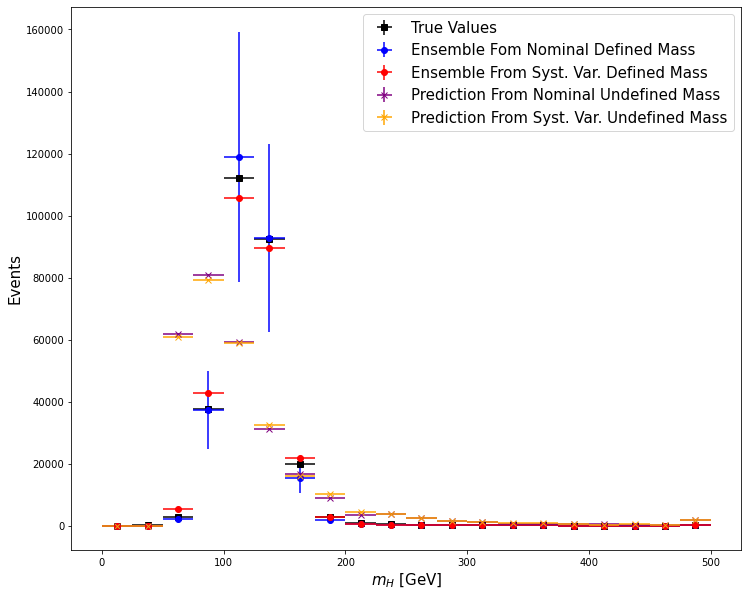

In [19]:
bin_width = 25

bins = np.arange(0,500, bin_width)

fig, axs = plt.subplots(figsize = (12,10))

plot_higgs_mass_histogram(axs, bins, y_train_test_nominal, 'True Values', color = 'black', marker='s', unit_normalize = False)

plot_higgs_mass_histogram(axs, bins, defined_mass_predictions_nominal_mean, 'Ensemble Fom Nominal Defined Mass', color = 'blue', unit_normalize = False, data_uncertainty = total_error)

plot_higgs_mass_histogram(axs, bins, defined_mass_predictions_systvar_mean, 'Ensemble From Syst. Var. Defined Mass', color = 'red', unit_normalize = False)

plot_higgs_mass_histogram(axs, bins, np.ravel(undef_mass_predictions_nominal) , 'Prediction From Nominal Undefined Mass', color = 'purple', marker = 'x', unit_normalize = False) 

plot_higgs_mass_histogram(axs, bins, np.ravel(undef_mass_predictions_systvar) , 'Prediction From Syst. Var. Undefined Mass', color = 'orange', marker = 'x', unit_normalize = False) 

axs.set_xlabel(r'$m_{H}$ [GeV]', fontsize = 15)

axs.set_ylabel('Events', fontsize = 15)

axs.legend(fontsize = 15)

# Summary
<font size="3"> As observed from the Higgs mass distribution plot, the true values of the Higgs mass (black) and the values obtained from the ensemble prediction of the systematically varied transverse momentum of the hadronically decaying tau (red) are in agreement with the Bayesian neural network predictions (blue) within the network's uncertainty. Additionally, the ensemble predictions of the nominal (purple) and systematically varied (orange) events with undefined Higgs mass behave similarly. Thus, we can conclude that the network is relatively unaffected by the systematic variation of the hadronically decaying tau $p_{T}$.</font>
    
<font size="3">It should be noted that the predictions of events with undefined Higgs mass don't agree with the predictions from the training data (defined mass). Additionally, the mass predictions peak at a lower value of the true Higgs boson mass ($m_{H} = 125$ GeV), possibly hinting at an issue in reconstructing the total energy of those events. As a potential next step, it would be interesting to consider systematic variations on quantities related to the missing energy of the event and propagate these uncertainties to the Bayesian neural network.</font>

<font size="3">Finally, I implemented a simple interpretation for the network's uncertainty by assuming that the errors can be modeled as errors from a distribution of bionomial random variables and where the predicted mass values for each event are assumed to be normally distributed. A more rigorous treatment of the uncertainty could be implemented by calculating the probability as the profile likelihood of the product of Poisson distribution terms that quantify the probability of observing $n$ events in each $m_{H}$ bin subject to $n_{\text{expected}}$ events, where $n_{\text{expected}}$ is obtained from the ensembles of the Bayesian neural network. The effects of the systematic variations can be included in the profile likelihood as Gaussian prior terms that reduce the likelihood when the systematically varied mass prediction differs significantly from the nominal prediction.</font>